In [2]:
from IPython.core.display import HTML
import os
import cv2
import random
import matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from keras.utils.np_utils import to_categorical
from keras.preprocessing.image import load_img, img_to_array
from keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import classification_report, log_loss, accuracy_score
from sklearn.model_selection import train_test_split

import PIL
from PIL import Image
from itertools import groupby

from keras.preprocessing.image import img_to_array
import PIL.ImageOps

In [3]:
display(HTML("""
<script>
code_show=true;
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
}
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()">
<center> <input type="image" width="100%" height="100%" alt="Click to toggle on/off the raw code" 
src='https://raw.githubusercontent.com/bdesagun/ml3_individual_project/master/ML3%20Individual%20Presentation.png' border="0"> </center>
</form>"""))

<div><span style="background-color: #38B6FF; padding-top: 100px; padding-right: 20px; padding-bottom: 50px; padding-left: 20px; color: #FFFFFF; font-size: 25px; font-weight: bold">INTRODUCTION</span></div>

Grading is a critical component of education. Most of the time, manually grading answer sheets and providing a fair, unbiased, and valid grade is a difficult and time consuming task. The goal of this project is to create a handwritten basic math equation solver capable of  checking answer sheets with multiple equations. 

From a given image, the application will be able to predict and solve handwritten mathematical equations. The system should be capable of solving expressions involving fundamental arithmetic operations such as addition, subtraction, multiplication, and division through the use of computer vision and convolutional neural network.


<div><span style="background-color: #38B6FF; padding-top: 100px; padding-right: 20px; padding-bottom: 50px; padding-left: 20px; color: #FFFFFF; font-size: 25px; font-weight: bold">EXPLORATORY DATA ANALYSIS</span></div>

### Data Source
The dataset used for this project is called `Handwritten Math Symbols` from kaggle. It an extension of the MNIST dataset with the inclusion of handwritten basic math operators. More details can be found on its <a href="https://www.kaggle.com/sagyamthapa/handwritten-math-symbols"> kaggle page.</a>



#### Contents
This dataset contains over 9000 handwritten digits and arithmetic operators.
Total no of classes: 16
Digits: 0 1 2 3 4 5 6 7 8 9
Operators: Plus Minus Multiplication Division Decimal Equals
Most images are of resolution 400x400 pixels. Some may be 155x155. I have resized image to 100x100 for in the started notebook.
Each class contains about 500 examples.[1]


A copy of the dataset was saved to the author's personal gdrive account and will be automatically downloaded and uncompressed by this report. This notebook uses `7zip` to uncompress the source files.

#### Dataset
Downloading the dataset from google drive.

In [15]:
"""Download dataset. """

!gdown --id '1-moBvhdpSXt24RbdHqEC_D7yweMdnZTK'

/Users/brian/opt/anaconda3/lib/python3.9/site-packages/gdown/cli.py:127: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1-moBvhdpSXt24RbdHqEC_D7yweMdnZTK
To: /Users/brian/Documents/AIM Files/Term4/final_project.zip
100%|██████████████████████████████████████| 41.3M/41.3M [00:07<00:00, 5.86MB/s]


#### Unzipping the dataset
Downloading the data set from gdrive.

In [37]:
"""Unzip (Mac). """

!7z x -y final_project.zip


7-Zip [64] 17.04 : Copyright (c) 1999-2021 Igor Pavlov : 2017-08-28
p7zip Version 17.04 (locale=utf8,Utf16=on,HugeFiles=on,64 bits,8 CPUs x64)

Scanning the drive for archives:
  0M Sca        1 file, 41296229 bytes (40 MiB)

Extracting archive: final_project.zip
 40% 4096 Op            --
Path = final_project.zip
Type = zip
Physical Size = 41296229

      1% 172 - dataset/0/41172.j                              2% 2        2% 3        4% 518 - dataset/0/RNZHrjfk.pn                                  6% 695 - dataset/1/30017.j                              7% 903 - dataset/1/66116.j                              8% 1122 - dataset/1/RIEAQgiv.p                                 10% 135         13% 1588 - dataset/2/xdjcpkfx.p                                 15% 1798 - dataset/3/56780.jp                               16% 1993 - dataset/3/95406.jp                               19% 213         20% 2298 - dataset/4/42240.jp                               21% 246         22% 2586 - dataset/4/96808.jp

The images are stored in their appropriate respective folders, in which the directory names will serve as their label.
Let's check how these images looks like. We'll print 10 samples from each category.

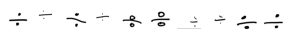

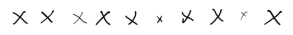

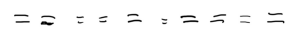

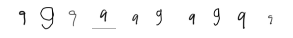

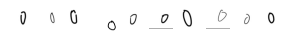

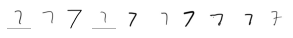

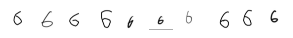

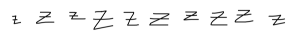

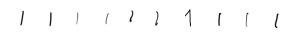

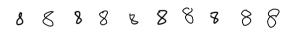

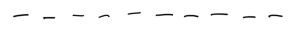

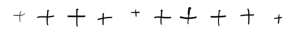

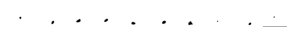

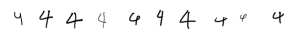

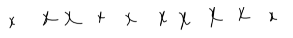

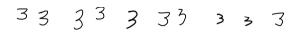

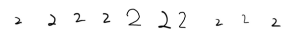

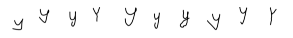

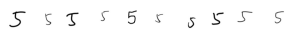

In [41]:
"""Print 10 sample images per category. """

obj = [x for x in os.listdir('dataset') if x[0] != '.']
for path in obj:
    image_path = f"dataset/{path}"
    n = 10
    files = os.listdir(image_path)
    z = list(map(lambda x: cv2.imread(os.path.join(image_path, x)),files))
    f, axarr = plt.subplots(1,n, figsize=(5,1) )
    for i,m in enumerate(axarr):
        m.imshow(z[i])
        m.get_xaxis().set_visible(False)
        m.get_yaxis().set_visible(False)   
        m.spines['top'].set_visible(False)
        m.spines['right'].set_visible(False)
        m.spines['bottom'].set_visible(False)
        m.spines['left'].set_visible(False)
    plt.show()
    

<center><b>Figure 1.</b> Sample data per category from the dataset </center>

Here, we plot the distribution per category.

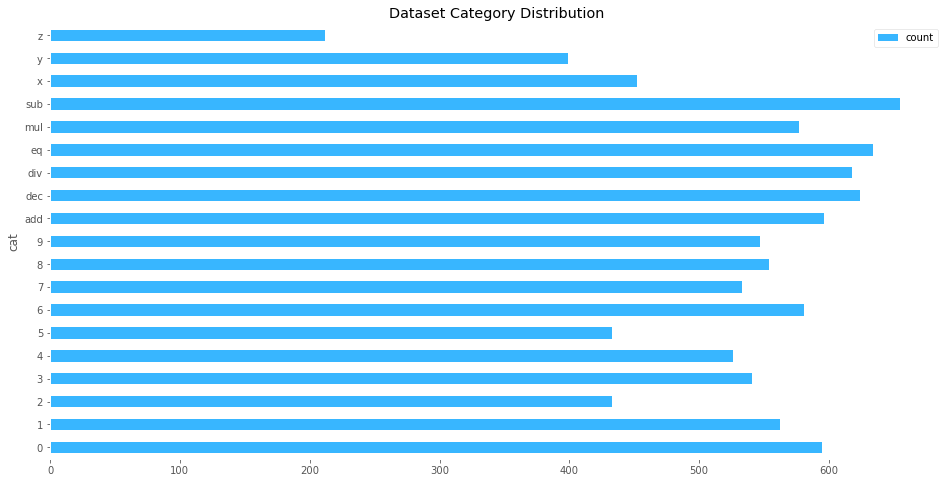

In [43]:
"""Print 10 sample images per category. """

matplotlib.style.use('ggplot')
plt.rcParams["figure.figsize"] = (16, 8)
plt.rcParams['axes.facecolor'] = 'white'


categories = []
cat_count = []
for dir in obj:
    cnt = 0
    for path in os.listdir(f"dataset/{dir}"):
        cnt += 1
    categories.append(dir)
    cat_count.append(cnt)
pd.DataFrame({
                'cat': categories,
                'count' : cat_count
             }).set_index('cat').sort_index().plot(kind='barh', color='#38B6FF')
plt.title('Dataset Category Distribution')
plt.show()

<center><b>Figure 2.</b> Dataset Category Ditribution </center>

## Model Training

####  Step 1. Train-test Split



We split the dataset into test and train and assign to variables trainx, testx, trainy, testy.

In [17]:
"""Train test split."""
directory = 'dataset'

Name = []
for file in os.listdir(directory):
    if file != '.directory' and file != '.DS_Store':
        Name += [file]

"""Print the classes. """
N = list(range(len(Name)))
normal_mapping = dict(zip(Name, N))
reverse_mapping = dict(zip(N, Name))


def mapper(value):
    return reverse_mapping[value]


dataset = []
testset = []
count = 0
for name in Name:
    path = os.path.join(directory, name)
    t = 0
    for im in os.listdir(path):
        if im[-4:] == '.jpg':
            image = load_img(os.path.join(path, im), grayscale=False,
                             color_mode='rgb', target_size=(40, 40))
            image = img_to_array(image)
            image = image/255.0
            if t < 500:
                dataset.append([image, count])
            else:
                testset.append([image, count])
            t += 1
    count = count+1


data, labels0 = zip(*dataset)
test, tlabels0 = zip(*testset)

labels1 = to_categorical(labels0)
data = np.array(data)
labels = np.array(labels1)

tlabels1 = to_categorical(tlabels0)
test = np.array(test)
tlabels = np.array(tlabels1)

trainx, testx, trainy, testy = train_test_split(
    data, labels, test_size=0.2, random_state=44)

####  Step 2. Model training

Following up on previous work in kaggle, I used a pretrained model called Densenet for feature extraction and then added a custom classification layer on top of that. [1]

DenseNet was developed specifically to improve the declined accuracy caused by the vanishing gradient in high-level neural networks. In simpler terms, due to the longer path between the input layer and the output layer, the information vanishes before reaching its destination.

Below is the model summary of the architecture use for model training.



In [20]:
"""Data Augmentation and model architecture. """

datagen = ImageDataGenerator(horizontal_flip=False, vertical_flip=False, rotation_range=20, zoom_range=0.2,
                             width_shift_range=0.2, height_shift_range=0.2, shear_range=0.1, fill_mode="nearest")

pretrained_model3 = tf.keras.applications.DenseNet201(input_shape=(
    40, 40, 3), include_top=False, weights='imagenet', pooling='avg')
pretrained_model3.trainable = False

inputs3 = pretrained_model3.input
x3 = tf.keras.layers.Dense(128, activation='relu')(pretrained_model3.output)
outputs3 = tf.keras.layers.Dense(16, activation='softmax')(x3)
model = tf.keras.Model(inputs=inputs3, outputs=outputs3)

model.compile(optimizer='adam', loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 40, 40, 3)]  0           []                               
                                                                                                  
 zero_padding2d_4 (ZeroPadding2  (None, 46, 46, 3)   0           ['input_3[0][0]']                
 D)                                                                                               
                                                                                                  
 conv1/conv (Conv2D)            (None, 20, 20, 64)   9408        ['zero_padding2d_4[0][0]']       
                                                                                                  
 conv1/bn (BatchNormalization)  (None, 20, 20, 64)   256         ['conv1/conv[0][0]']       

                                                                                                  
 conv2_block4_1_bn (BatchNormal  (None, 10, 10, 128)  512        ['conv2_block4_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block4_1_relu (Activatio  (None, 10, 10, 128)  0          ['conv2_block4_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block4_2_conv (Conv2D)   (None, 10, 10, 32)   36864       ['conv2_block4_1_relu[0][0]']    
                                                                                                  
 conv2_block4_concat (Concatena  (None, 10, 10, 192)  0          ['conv2_block3_concat[0][0]',    
 te)      

 conv3_block2_1_conv (Conv2D)   (None, 5, 5, 128)    20480       ['conv3_block2_0_relu[0][0]']    
                                                                                                  
 conv3_block2_1_bn (BatchNormal  (None, 5, 5, 128)   512         ['conv3_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block2_1_relu (Activatio  (None, 5, 5, 128)   0           ['conv3_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block2_2_conv (Conv2D)   (None, 5, 5, 32)     36864       ['conv3_block2_1_relu[0][0]']    
                                                                                                  
 conv3_blo

                                                                                                  
 conv3_block6_2_conv (Conv2D)   (None, 5, 5, 32)     36864       ['conv3_block6_1_relu[0][0]']    
                                                                                                  
 conv3_block6_concat (Concatena  (None, 5, 5, 320)   0           ['conv3_block5_concat[0][0]',    
 te)                                                              'conv3_block6_2_conv[0][0]']    
                                                                                                  
 conv3_block7_0_bn (BatchNormal  (None, 5, 5, 320)   1280        ['conv3_block6_concat[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block7_0_relu (Activatio  (None, 5, 5, 320)   0           ['conv3_block7_0_bn[0][0]']      
 n)       

 lization)                                                                                        
                                                                                                  
 conv3_block11_0_relu (Activati  (None, 5, 5, 448)   0           ['conv3_block11_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv3_block11_1_conv (Conv2D)  (None, 5, 5, 128)    57344       ['conv3_block11_0_relu[0][0]']   
                                                                                                  
 conv3_block11_1_bn (BatchNorma  (None, 5, 5, 128)   512         ['conv3_block11_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv3_blo

 conv4_block3_0_bn (BatchNormal  (None, 2, 2, 320)   1280        ['conv4_block2_concat[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block3_0_relu (Activatio  (None, 2, 2, 320)   0           ['conv4_block3_0_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block3_1_conv (Conv2D)   (None, 2, 2, 128)    40960       ['conv4_block3_0_relu[0][0]']    
                                                                                                  
 conv4_block3_1_bn (BatchNormal  (None, 2, 2, 128)   512         ['conv4_block3_1_conv[0][0]']    
 ization)                                                                                         
          

                                                                                                  
 conv4_block7_1_bn (BatchNormal  (None, 2, 2, 128)   512         ['conv4_block7_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block7_1_relu (Activatio  (None, 2, 2, 128)   0           ['conv4_block7_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block7_2_conv (Conv2D)   (None, 2, 2, 32)     36864       ['conv4_block7_1_relu[0][0]']    
                                                                                                  
 conv4_block7_concat (Concatena  (None, 2, 2, 480)   0           ['conv4_block6_concat[0][0]',    
 te)      

 conv4_block11_2_conv (Conv2D)  (None, 2, 2, 32)     36864       ['conv4_block11_1_relu[0][0]']   
                                                                                                  
 conv4_block11_concat (Concaten  (None, 2, 2, 608)   0           ['conv4_block10_concat[0][0]',   
 ate)                                                             'conv4_block11_2_conv[0][0]']   
                                                                                                  
 conv4_block12_0_bn (BatchNorma  (None, 2, 2, 608)   2432        ['conv4_block11_concat[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block12_0_relu (Activati  (None, 2, 2, 608)   0           ['conv4_block12_0_bn[0][0]']     
 on)                                                                                              
          

                                                                                                  
 conv4_block16_0_relu (Activati  (None, 2, 2, 736)   0           ['conv4_block16_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block16_1_conv (Conv2D)  (None, 2, 2, 128)    94208       ['conv4_block16_0_relu[0][0]']   
                                                                                                  
 conv4_block16_1_bn (BatchNorma  (None, 2, 2, 128)   512         ['conv4_block16_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block16_1_relu (Activati  (None, 2, 2, 128)   0           ['conv4_block16_1_bn[0][0]']     
 on)      

 lization)                                                                                        
                                                                                                  
 conv4_block20_1_relu (Activati  (None, 2, 2, 128)   0           ['conv4_block20_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block20_2_conv (Conv2D)  (None, 2, 2, 32)     36864       ['conv4_block20_1_relu[0][0]']   
                                                                                                  
 conv4_block20_concat (Concaten  (None, 2, 2, 896)   0           ['conv4_block19_concat[0][0]',   
 ate)                                                             'conv4_block20_2_conv[0][0]']   
                                                                                                  
 conv4_blo

 conv4_block24_concat (Concaten  (None, 2, 2, 1024)  0           ['conv4_block23_concat[0][0]',   
 ate)                                                             'conv4_block24_2_conv[0][0]']   
                                                                                                  
 conv4_block25_0_bn (BatchNorma  (None, 2, 2, 1024)  4096        ['conv4_block24_concat[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block25_0_relu (Activati  (None, 2, 2, 1024)  0           ['conv4_block25_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block25_1_conv (Conv2D)  (None, 2, 2, 128)    131072      ['conv4_block25_0_relu[0][0]']   
          

 on)                                                                                              
                                                                                                  
 conv4_block29_1_conv (Conv2D)  (None, 2, 2, 128)    147456      ['conv4_block29_0_relu[0][0]']   
                                                                                                  
 conv4_block29_1_bn (BatchNorma  (None, 2, 2, 128)   512         ['conv4_block29_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block29_1_relu (Activati  (None, 2, 2, 128)   0           ['conv4_block29_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_blo

 conv4_block33_1_relu (Activati  (None, 2, 2, 128)   0           ['conv4_block33_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block33_2_conv (Conv2D)  (None, 2, 2, 32)     36864       ['conv4_block33_1_relu[0][0]']   
                                                                                                  
 conv4_block33_concat (Concaten  (None, 2, 2, 1312)  0           ['conv4_block32_concat[0][0]',   
 ate)                                                             'conv4_block33_2_conv[0][0]']   
                                                                                                  
 conv4_block34_0_bn (BatchNorma  (None, 2, 2, 1312)  5248        ['conv4_block33_concat[0][0]']   
 lization)                                                                                        
          

                                                                                                  
 conv4_block38_0_bn (BatchNorma  (None, 2, 2, 1440)  5760        ['conv4_block37_concat[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block38_0_relu (Activati  (None, 2, 2, 1440)  0           ['conv4_block38_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block38_1_conv (Conv2D)  (None, 2, 2, 128)    184320      ['conv4_block38_0_relu[0][0]']   
                                                                                                  
 conv4_block38_1_bn (BatchNorma  (None, 2, 2, 128)   512         ['conv4_block38_1_conv[0][0]']   
 lization)

 conv4_block42_1_conv (Conv2D)  (None, 2, 2, 128)    200704      ['conv4_block42_0_relu[0][0]']   
                                                                                                  
 conv4_block42_1_bn (BatchNorma  (None, 2, 2, 128)   512         ['conv4_block42_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block42_1_relu (Activati  (None, 2, 2, 128)   0           ['conv4_block42_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block42_2_conv (Conv2D)  (None, 2, 2, 32)     36864       ['conv4_block42_1_relu[0][0]']   
                                                                                                  
 conv4_blo

                                                                                                  
 conv4_block46_2_conv (Conv2D)  (None, 2, 2, 32)     36864       ['conv4_block46_1_relu[0][0]']   
                                                                                                  
 conv4_block46_concat (Concaten  (None, 2, 2, 1728)  0           ['conv4_block45_concat[0][0]',   
 ate)                                                             'conv4_block46_2_conv[0][0]']   
                                                                                                  
 conv4_block47_0_bn (BatchNorma  (None, 2, 2, 1728)  6912        ['conv4_block46_concat[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block47_0_relu (Activati  (None, 2, 2, 1728)  0           ['conv4_block47_0_bn[0][0]']     
 on)      

 n)                                                                                               
                                                                                                  
 conv5_block2_2_conv (Conv2D)   (None, 1, 1, 32)     36864       ['conv5_block2_1_relu[0][0]']    
                                                                                                  
 conv5_block2_concat (Concatena  (None, 1, 1, 960)   0           ['conv5_block1_concat[0][0]',    
 te)                                                              'conv5_block2_2_conv[0][0]']    
                                                                                                  
 conv5_block3_0_bn (BatchNormal  (None, 1, 1, 960)   3840        ['conv5_block2_concat[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_blo

 conv5_block7_0_bn (BatchNormal  (None, 1, 1, 1088)  4352        ['conv5_block6_concat[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block7_0_relu (Activatio  (None, 1, 1, 1088)  0           ['conv5_block7_0_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_block7_1_conv (Conv2D)   (None, 1, 1, 128)    139264      ['conv5_block7_0_relu[0][0]']    
                                                                                                  
 conv5_block7_1_bn (BatchNormal  (None, 1, 1, 128)   512         ['conv5_block7_1_conv[0][0]']    
 ization)                                                                                         
          

                                                                                                  
 conv5_block11_1_bn (BatchNorma  (None, 1, 1, 128)   512         ['conv5_block11_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv5_block11_1_relu (Activati  (None, 1, 1, 128)   0           ['conv5_block11_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv5_block11_2_conv (Conv2D)  (None, 1, 1, 32)     36864       ['conv5_block11_1_relu[0][0]']   
                                                                                                  
 conv5_block11_concat (Concaten  (None, 1, 1, 1248)  0           ['conv5_block10_concat[0][0]',   
 ate)     

 conv5_block15_2_conv (Conv2D)  (None, 1, 1, 32)     36864       ['conv5_block15_1_relu[0][0]']   
                                                                                                  
 conv5_block15_concat (Concaten  (None, 1, 1, 1376)  0           ['conv5_block14_concat[0][0]',   
 ate)                                                             'conv5_block15_2_conv[0][0]']   
                                                                                                  
 conv5_block16_0_bn (BatchNorma  (None, 1, 1, 1376)  5504        ['conv5_block15_concat[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv5_block16_0_relu (Activati  (None, 1, 1, 1376)  0           ['conv5_block16_0_bn[0][0]']     
 on)                                                                                              
          

                                                                                                  
 conv5_block20_0_relu (Activati  (None, 1, 1, 1504)  0           ['conv5_block20_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv5_block20_1_conv (Conv2D)  (None, 1, 1, 128)    192512      ['conv5_block20_0_relu[0][0]']   
                                                                                                  
 conv5_block20_1_bn (BatchNorma  (None, 1, 1, 128)   512         ['conv5_block20_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv5_block20_1_relu (Activati  (None, 1, 1, 128)   0           ['conv5_block20_1_bn[0][0]']     
 on)      

 lization)                                                                                        
                                                                                                  
 conv5_block24_1_relu (Activati  (None, 1, 1, 128)   0           ['conv5_block24_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv5_block24_2_conv (Conv2D)  (None, 1, 1, 32)     36864       ['conv5_block24_1_relu[0][0]']   
                                                                                                  
 conv5_block24_concat (Concaten  (None, 1, 1, 1664)  0           ['conv5_block23_concat[0][0]',   
 ate)                                                             'conv5_block24_2_conv[0][0]']   
                                                                                                  
 conv5_blo

 conv5_block28_concat (Concaten  (None, 1, 1, 1792)  0           ['conv5_block27_concat[0][0]',   
 ate)                                                             'conv5_block28_2_conv[0][0]']   
                                                                                                  
 conv5_block29_0_bn (BatchNorma  (None, 1, 1, 1792)  7168        ['conv5_block28_concat[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv5_block29_0_relu (Activati  (None, 1, 1, 1792)  0           ['conv5_block29_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv5_block29_1_conv (Conv2D)  (None, 1, 1, 128)    229376      ['conv5_block29_0_relu[0][0]']   
          

 avg_pool (GlobalAveragePooling  (None, 1920)        0           ['relu[0][0]']                   
 2D)                                                                                              
                                                                                                  
 dense_2 (Dense)                (None, 128)          245888      ['avg_pool[0][0]']               
                                                                                                  
 dense_3 (Dense)                (None, 16)           2064        ['dense_2[0][0]']                
                                                                                                  
Total params: 18,569,936
Trainable params: 247,952
Non-trainable params: 18,321,984
__________________________________________________________________________________________________


After that, the model was trained for ten epochs, yielding a 91 percent accuracy. The model's performance on the test dataset is shown in Figures 3, 4, and 5.

In [39]:
"""Model training process."""

his=model.fit(datagen.flow(trainx,trainy,batch_size=32),validation_data=(testx,testy),epochs=10)

y_pred=model.predict(testx)
pred=np.argmax(y_pred,axis=1)

ground = np.argmax(testy,axis=1)
print(classification_report(ground,pred))

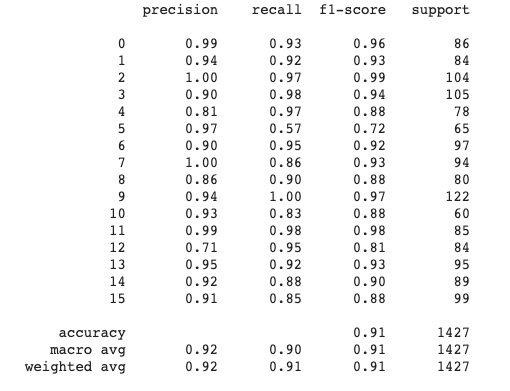

<div style="font-size:14px; font-weight: bold; text-align: center">
Figure 3. Training Classification Report
</div>


In [24]:
"""Training vs validation accuracy."""

get_acc = his.history['accuracy']
value_acc = his.history['val_accuracy']
get_loss = his.history['loss']
validation_loss = his.history['val_loss']

epochs = range(len(get_acc))
plt.plot(epochs, get_acc, 'r', label='Accuracy of Training data')
plt.plot(epochs, value_acc, 'b', label='Accuracy of Validation data')
plt.title('Training vs validation accuracy')
plt.legend(loc=0)
plt.figure()
plt.show()

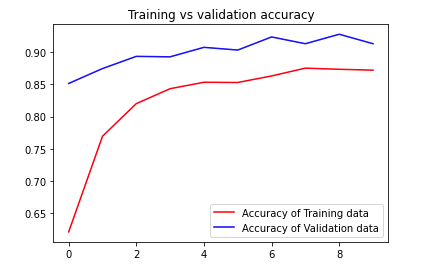

<div style="font-size:14px; font-weight: bold; text-align: center">
Figure 4. Training vs Validation Accuracy
</div>



In [ ]:
"""Training vs validation loss."""

epochs = range(len(get_loss))
plt.plot(epochs, get_loss, 'r', label='Loss of Training data')
plt.plot(epochs, validation_loss, 'b', label='Loss of Validation data')
plt.title('Training vs validation loss')
plt.legend(loc=0)
plt.figure()
plt.show()

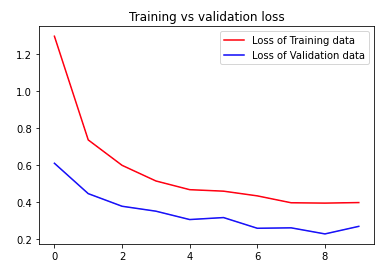

<div style="font-size:14px; font-weight: bold; text-align: center">
Figure 5. Training vs Validation Loss
</div>


####  Step 3. Saving the model

Finally, the trained model is saved as a h5 file, which will be used in the solution pipeline to predict handwritten digits.

In [25]:
"""Save model. """

model.save("final_project.h5")

<div><span style="background-color: #38B6FF; padding-top: 100px; padding-right: 20px; padding-bottom: 50px; padding-left: 20px; color: #FFFFFF; font-size: 25px; font-weight: bold">SOLUTION METHODOLOGY</span></div>

To build a basic handwritten math equation solver, the solution is divided into three major processes:

* Image pre-processing
* Model Inferencing
* Equation solving

The following sections provide a detailed description of each process. Figure 6 below represents the basic overall flow of the solution methodology.



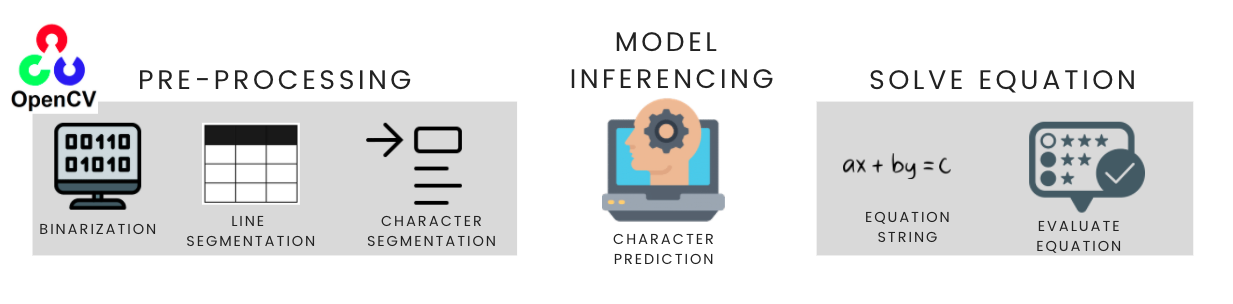

<div style="font-size:14px; font-weight: bold; text-align: center">
Figure 6. Solution Methodology Overview
</div>

### Image pre-processing



This notebook comes with a python file named helper.py that contains some functions that are used for image pre-processing. To process images, OpenCV and PIL are used..

In [6]:
from helper import *

#####  Binarization and Line Segmentation

The attached handwritten math equations, as shown in Figure 7, will be used to demonstrate the concept in this 
notebook.

The first step is to binarize the equations and look for significant gaps between them in order to separate them. Every detected equation is represented by a rectangle, and each equation is then evaluated one by one until all of the equations have been processed. Figure 8 shows the binarized image with the rectagle boxes that separate the equations from the input image.

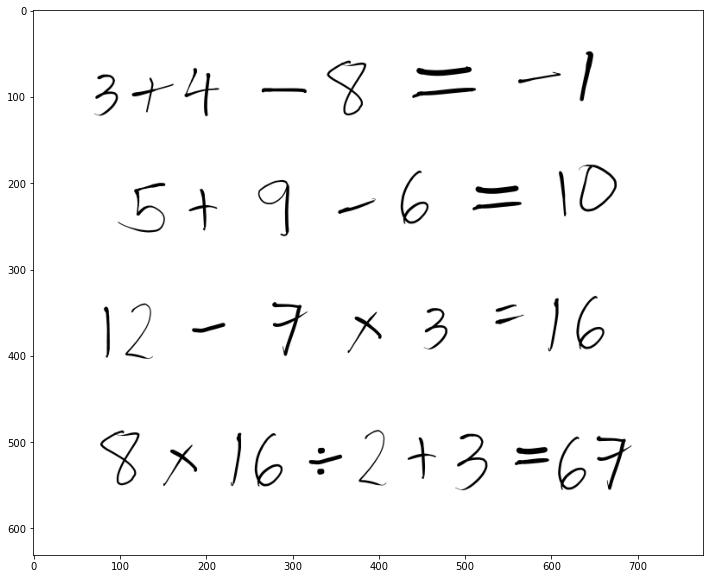

In [7]:
""" Load test image. """

image_path = 'images/test_image2.png'
img = cv2.imread(image_path)
clone = img.copy()

thresh = 120
im_bw = cv2.threshold(img, thresh, 255, cv2.THRESH_BINARY)[1]
img = im_bw
plt.figure(figsize=(12,12))
plt.imshow(clone)


<div style="font-size:14px; font-weight: bold; text-align: center">
Figure 7. Sample Image for Demonstration
</div>

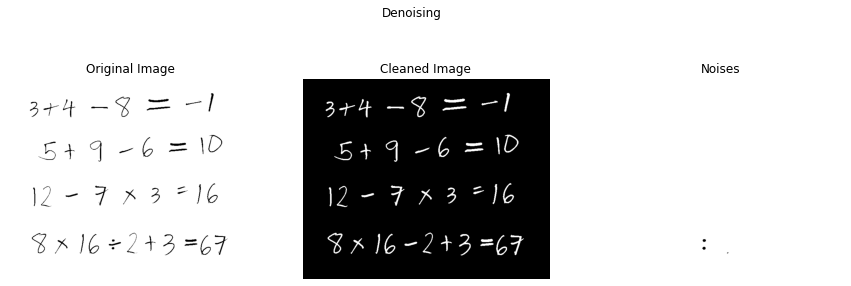

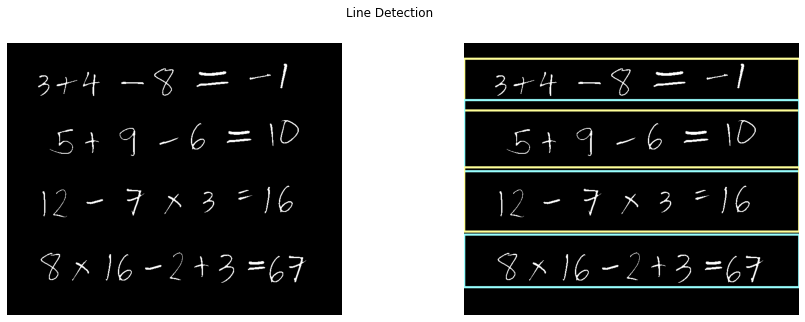

In [8]:
""" Binarization and line segmentation. """

cleaned_orig,y1s,y2s,rec_out = extract_line(img, show=True)

<div style="font-size:14px; font-weight: bold; text-align: center">
Figure 8. Binarized and Line Detected images
</div>

#####  Character Segmentation

As previously stated, each equation from the preceding step will be evaluated one at a time in the subsequent step. Characters from each of the equations will be segmented and reshaped into the same size as the input for the model thas was trained in the ealier section. 

Figure 9 shows the segmented characters reshaped to 40x40 pixels for the third equation from the sample input image.

In [11]:
""" Character segmentation. """

backtorgb = 255 - cv2.cvtColor(cleaned_orig, cv2.COLOR_GRAY2RGB)
i = rec_out[2]
img_interest = backtorgb[i[0][1]:i[1][1], i[0][0]:i[1][0]]
image = Image.fromarray(img_interest).convert('RGB').convert("L")
new_image_arr = np.array(image)
reverse_img = 255 - new_image_arr
ooooo = reverse_img[reverse_img.sum(axis=1).nonzero()]
padding = np.zeros(shape=(5, reverse_img.shape[1]))
image = np.concatenate((padding, ooooo, padding))
image_i = PIL.ImageOps.invert(Image.fromarray(image).convert('RGB').convert('L'))

'resizing to 28 height pixels'
image = image_i
w = image.size[0]
h = image.size[1]
r = w / h  # aspect ratio
new_w = int(r * 40)
new_h = 40
new_image = image.resize((new_w, new_h))
new_image

'converting to a numpy array'
new_image_arr = np.array(new_image)
# new_image_arr = np.array(image)

'inverting the image to make background = 0'
new_inv_image_arr = 255 - new_image_arr
# new_inv_image_arr = new_image_arr

'rescaling the image'
final_image_arr = new_inv_image_arr / 255.0

'splitting image array into individual element arrays using non zero columns'
m = final_image_arr.any(0)
out = [final_image_arr[:, [*g]]
       for k, g in groupby(np.arange(len(m)), lambda x: m[x] != 0) if k]


num_of_elements = len(out)
elements_list = []
for x in range(0, num_of_elements):
    img = out[x]
    
    #adding 0 value columns as fillers
    width = img.shape[1]
    filler = (final_image_arr.shape[0] - width) / 2
    
    if filler.is_integer() == False:    #odd number of filler columns
        filler_l = int(filler)
        filler_r = int(filler) + 1
    else:                               #even number of filler columns
        filler_l = int(filler)
        filler_r = int(filler)
    
    arr_l = np.zeros((final_image_arr.shape[0], filler_l)) #left fillers
    arr_r = np.zeros((final_image_arr.shape[0], filler_r)) #right fillers
    
    #concatinating the left and right fillers
    help_ = np.concatenate((arr_l, img), axis= 1)
    element_arr = np.concatenate((help_, arr_r), axis= 1)
    
    element_arr.resize(40, 40, 1) #resize array 2d to 3d
    #storing all elements in a list
    elements_list.append(element_arr)
elements_array = np.array(elements_list)
elements_array = elements_array.reshape(-1, 40, 40, 1)

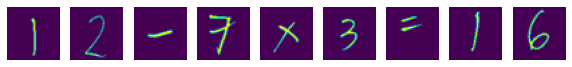

In [12]:
""" Plot segmented characters. """

f, axarr = plt.subplots(1,len(elements_array), figsize=(10,5) )
for i,m in enumerate(axarr):
    m.imshow(elements_array[i])
    m.get_xaxis().set_visible(False)
    m.get_yaxis().set_visible(False)   
    m.spines['top'].set_visible(False)
    m.spines['right'].set_visible(False)
    m.spines['bottom'].set_visible(False)
    m.spines['left'].set_visible(False)
plt.show()


<div style="font-size:14px; font-weight: bold; text-align: center">
Figure 9. Segmented Characters reshaped to 40x40 pixels
</div>

### Model Inferencing

Next, each character will be predicted and converted into a string value using the trained model that was previously demonstrated. 

The current model is not perfect, and further optimization could be used to improve the accuracy of the predictions. One of its flaws is that some characters are predicted more favorably than others. As an example, the number 7 is heavily favored when compared to the number 2. For the time being, custom class weights are used to generate correct predictions in order to temporarily resolve the problem.

The output of the prediction function is a list of string value predictions from the input images as shown below.

In [13]:
from tensorflow import keras

In [16]:
""" Model inferencing. """

model = keras.models.load_model("models/attempt2.h5") # pre-trained. used for flask
Name = ['1', '+', '.', '==', '3', '2', '6', '/', '9', '*', '5',
        '0', '7', '-', '8', '4']


def prediction(elements_array):
    # Give 2 a higher custom weight since it is always predicted as 7
    custom_weights = np.ones(16)
    custom_weights[[3, 5, 10]] = [9.7,19.8,2.5]

    p1 = [Image.fromarray(np.uint8(np.reshape(o, (40, 40)) * 255),
                          'L').convert('RGB') for o in elements_array]
    p2 = [np.expand_dims(np.array(img_to_array(
        PIL.ImageOps.invert(i))/255), axis=0) for i in p1]
    prediction = [
        Name[np.argmax(model.predict(p) * custom_weights)] for p in p2]
    return prediction

prediction(elements_array)

['1', '2', '-', '7', '*', '3', '==', '1', '6']

### Solving the Equation

The simpliest yet the most important step is the evaluation of the equation. The eval method in python can be used to solve basic math equation. Shown below is the result for the example equation.


In [15]:
""" Solving the equation. """

eq = ''.join(prediction(elements_array))
print(eq,' RESULT: ', eval(eq))

12-7*3==16  RESULT:  False


<div><span style="background-color: #38B6FF; padding-top: 100px; padding-right: 20px; padding-bottom: 50px; padding-left: 20px; color: #FFFFFF; font-size: 25px; font-weight: bold">RESULTS AND DISCUSSIONS</span></div>

This project demonstrated the use of a basic convolutional neural network model that has the potential to have a significant impact. The pipeline, and how all the components are linked together to create a complete package is the key to the solution this project is aiming to achieve.

Flask was used to create a frontend web application that follows the methodology outlined in this report as the backend process. The app will allow users to upload a photo or take a picture with their phone's camera. The image will be assessed, and the results will be returned to the online interface. Figure 10 and 11 shows the implementation flow of the application and a sample output.

All scripts, test images and flask deployment can be found in the github link provided below. 

https://github.com/bdesagun/ml3_individual_project.git


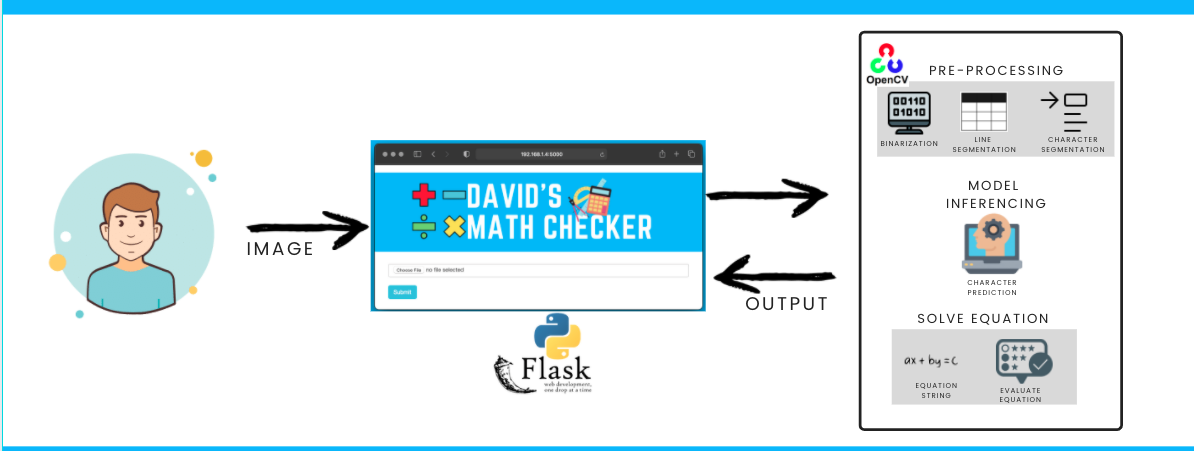

<div style="font-size:14px; font-weight: bold; text-align: center">
Figure 10. Implementation Flow
</div>

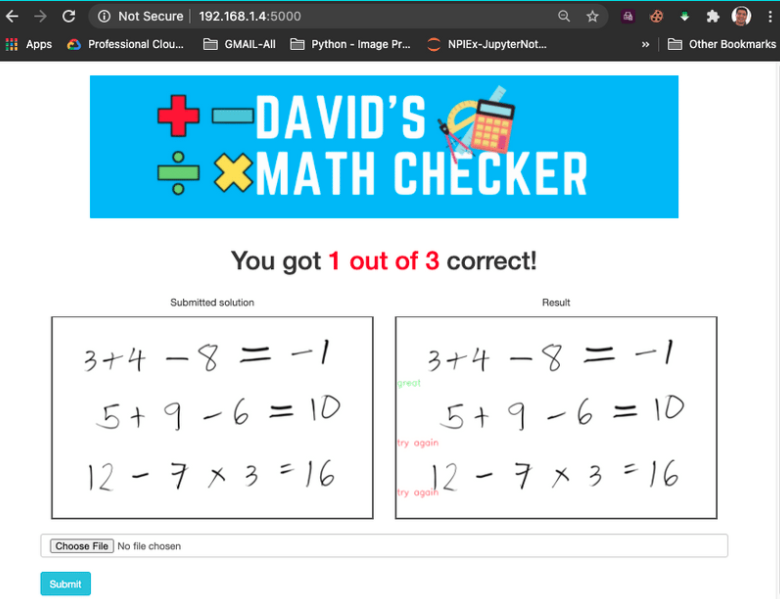
<div style="font-size:14px; font-weight: bold; text-align: center">
Figure 11. Sample Output from the Web Interface
</div>

<div><span style="background-color: #38B6FF; padding-top: 100px; padding-right: 20px; padding-bottom: 50px; padding-left: 20px; color: #FFFFFF; font-size: 25px; font-weight: bold">CONCLUSIONS AND RECOMMENDATIONS</span></div>

The solution is far from perfect, and there are numerous improvements that may be made to make it even better. 

As mentioned in the model inferencing sections, custom class weights were assigned to some classes to adjust biases with incorrect model predictions. As this is just a temporary solution, this can be corrected by fine tuning the model and adding more to the input training images. 

Binarization, line segmentation and character segmentation processes  can all be improved by automating the threshold selection. The current solution only works with modest clean images and fails if there is a lot of noise in the input image. Alternatively, existing pre-trained Optical Character Recognition (OCR) models may be used to better segment the lines and characters.

Finally, the project could be extended to handle more complicated mathematical problems and automate the grading of multi-line math solutions, which would be particularly beneficial for providing partial grading of incorrect math answers.

<div><span style="background-color: #38B6FF; padding-top: 100px; padding-right: 20px; padding-bottom: 50px; padding-left: 20px; color: #FFFFFF; font-size: 25px; font-weight: bold">REFERENCES</span></div>

[0]
“Math Symbol Classify DenseNet201”. [Online]. Available: https://www.kaggle.com/stpeteishii/math-symbol-classify-densenet201/data. [Accessed: 01-Mar.-2022].

[1]
“Computer Vision — Auto grading Handwritten Mathematical ...”. [Online]. Available: https://towardsdatascience.com/computer-vision-auto-grading-handwritten-mathematical-answersheets-8974744f72dd. [Accessed: 11-Mar.-2022].

